In [1]:
import pandas as pd
import openpyxl
import h5py
import cv2
import numpy as np
import os
import sys
sys.path.append('C:/Users/w37262do/Documents/git/PyIR/src')
import spectral_preprocessing as sp
from matplotlib import pyplot as plt

## Define utility functions

In [2]:
def load_from_master(sheet_name, merge_annotations=False):
    master = pd.read_excel(sheet_name)
    he_filepaths = master['segmented HE filepath'].to_numpy()
    hdf5_filepaths = master['hdf5_filepaths'].to_numpy()

    t_or_n = master['T or N'].to_numpy()
    slides = master['Slide'].to_numpy()
    p_ids = master['Patient ID'].to_numpy()
    c_ids = master['Core Id'].to_numpy()

    path_infos = master['path_info'].to_numpy().astype(str)
    path_prepend = r'C:/Users/w37262do/Datasets/pcuk_2023/H_E_segmented'
    path_prepend_mask = r'C:/Users/w37262do/Datasets/pcuk_2023/H_E_segmented_tissuemasks'
    path_prepend_hdf5 = r'D:/workspace/code/PcrUK/PcrUK/HDF5 Data 3D'

    he_filepaths = np.array(
            [f"{path_prepend}/Slide {slides[x]}/" + he_filepath.split("/")[-1]
             for x,he_filepath in enumerate(he_filepaths)])
    mask_filepaths = np.array(
            [f"{path_prepend_mask}/Slide {slides[x]}/" + he_filepath.split("/")[-1]
             for x,he_filepath in enumerate(he_filepaths)])
    hdf5_filepaths = np.array([path_prepend_hdf5 + path.split('HDF5 Data')[-1] for path in hdf5_filepaths])
    hdf5_filepaths = np.array(
        [path.replace('D:/workspace/code/PcrUK/PcrUK', 'C:/Users/w37262do/Datasets/pcuk_2023').replace('DataCube/', '')
         for path in hdf5_filepaths])

    if not merge_annotations:
        return he_filepaths,hdf5_filepaths,mask_filepaths,t_or_n,slides,p_ids,c_ids,path_infos
    else:

        indexes = []
        indexes_keep = []
        annot_filepaths = []
        ## Load in the annotation files
        for s in list(set(slides)):
            annot_root = f'E:/workspace/code/PcrUK/PcrUK/annotations/Slide {s}/'
            for path in os.listdir(annot_root):
                if 'annotation' not in path: continue
                core_id = path.split('annotations')[0].split(' ')[-2]
                i = np.where(np.logical_and(slides == int(s), c_ids == int(core_id)))[0]
                if len(i) != 1: continue;
                indexes.append(i[0])
                indexes_keep.append(i[0])
                annot_filepaths.append(annot_root + path)

        ## Reconcile differenes between master and annotations
        indexes = np.array(indexes)
        he_filepaths = he_filepaths[indexes]
        hdf5_filepaths = hdf5_filepaths[indexes]
        t_or_n = t_or_n[indexes]
        slides = slides[indexes]
        p_ids = p_ids[indexes]
        c_ids = c_ids[indexes]
        path_infos = path_infos[indexes]
        indexes = np.arange(0, len(he_filepaths))

        return he_filepaths, hdf5_filepaths, mask_filepaths, t_or_n, slides, p_ids, c_ids, path_infos, annot_filepaths, indexes
    
def process_core_from_path(filepath,transform):
    core = h5py.File(filepath)['data/intensities'][:]
    mask = h5py.File(filepath)['data/tissue_mask'][:]
    wavenumbers = h5py.File(filepath)['data/wavenumbers'][:]
    shape = np.array(core.shape[:-1])
    core = core.reshape(np.prod(shape),-1); mask = mask.flatten()
    core, wavenumbers, mask = transform(core, wavenumbers, mask)
    core = core.reshape(*shape,-1); mask = mask.reshape(*shape)
    return core,wavenumbers,mask,shape

## Define dataset parameters

In [3]:
target_width = target_height = tw = th = 256

sheet_path = r'../lbp_3d/data/master_linked.xlsx'
he_filepaths, hdf5_filepaths, mask_filepaths, t_or_n, slides, p_ids, c_ids, path_infos, annot_filepaths, indexes = load_from_master(sheet_path,merge_annotations=True)
print(f"Dataset size: {len(he_filepaths)} items")

# Define preprocessing transform
tclass = sp.Dougal2024_2ndderiv()
transform = tclass.trans_func
print(f"Using transformation: {tclass.name}")
annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0],[0,255,255],[255,255,0],])#[127,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood',"crushed","immune_infiltrate"])#,

Dataset size: 235 items
Using transformation: Dougal Transform 2, with second derivative


## Creation loop

In [4]:
root_dir = r'D:/datasets/pcuk2023_ftir_whole_core_2024'

new_sheet_data = {
    'slide':[],
    'core_id':[],
    'patient_id':[],
    't_or_n':[],
    'pathology_info':[],
    'annotated_pixels':[],
    'hdf5_filepath':[],
    'annotation_filepath':[],
    'chemical_image_filepath':[],
    'mask_filepath':[],
}

#print(f"Processing cores, on core: ",end="\r")
for core_idx in range(0,len(hdf5_filepaths)):
    # get data from master sheet
    hdf5_path = hdf5_filepaths[core_idx]
    print(f"Processing cores, on core: {core_idx+1}/{len(hdf5_filepaths)}, {hdf5_path.split('/')[-1]}",end="")
    annot_path = annot_filepaths[core_idx]
    chemical_path = annot_filepaths[core_idx].replace(" annotations"," chemical")
    tn = t_or_n[core_idx]
    pathology = path_infos[core_idx]
    s = slides[core_idx]
    p = p_ids[core_idx]
    c = c_ids[core_idx]
    
    # Load data from disk
    core,wavenumbers,mask,shape = process_core_from_path(hdf5_path,transform=transform)
    annotations = cv2.imread(annot_path)
    chemical = cv2.imread(chemical_path)
    if core is None or annotations is None or chemical is None:
        print(" skipping, missing chemical img or annotations")
        continue
    chemical = chemical[:,:,1]
    annotations = annotations[:,:,::-1]
    
    annotation_mask = np.zeros((*shape,6))
    for tissue_class in range(6):
        annotation_mask[:,:,tissue_class] = np.all(annotations == annotation_class_colors[tissue_class].reshape(1,1,-1),axis=-1)
    if annotation_mask.sum() == 0:
        print(" skipping, no annotated pixels")
        continue
    else:
        annotated_pixels = annotation_mask.sum()
        
    # pad/transform data  
    core_height,core_width,_ = core.shape
    if core_height >256:
        core = core[core_height-256:]
        chemical = chemical[core_height-256:]
        annotations = annotations[core_height-256:]
        mask = mask[core_height-256:]
    if core_width >256:
        core = core[:,core_width-256:]
        chemical = chemical[:,core_width-256:]
        annotations = annotations[:,core_width-256:]
        mask = mask[:,core_width-256:]
    core_height,core_width,_ = core.shape
    top_pad = (target_height - core_height)//2
    bot_pad = (target_height - core_height)//2 + (target_height - core_height)%2
    left_pad = (target_width - core_width)//2
    right_pad = (target_width - core_width)//2 + (target_width - core_width)%2
    core = np.pad(core,((top_pad,bot_pad),(left_pad,right_pad),(0,0)),'edge')
    mask = np.pad(mask,((top_pad,bot_pad),(left_pad,right_pad)),'constant',constant_values=0)
    annotations = np.pad(annotations,((top_pad,bot_pad),(left_pad,right_pad),(0,0)),'constant',constant_values=0)
    chemical = np.pad(chemical,((top_pad,bot_pad),(left_pad,right_pad)),'constant',constant_values=0)
    
    # save data to disk
    spectral_savepath = f'{root_dir}/spectral/s{s:0>{2}}_c{c:0>{3}}.h5'
    chemical_savepath = f'{root_dir}/chemical/s{s:0>{2}}_c{c:0>{3}}.png'
    annotation_savepath =f'{root_dir}/annotation/s{s:0>{2}}_c{c:0>{3}}.png'
    mask_savepath =f'{root_dir}/mask/s{s:0>{2}}_c{c:0>{3}}.png'
    
    hf = h5py.File(spectral_savepath, 'w')
    #hf.create_dataset('spectra', data=core, compression='lzf')
    hf.create_dataset('spectra', data=core.astype(np.float32), compression='lzf',chunks=(13,13,193))
    hf.create_dataset('mask', data=mask.astype(np.float32), compression='lzf',chunks=(13,13))
    hf.close()
    cv2.imwrite(chemical_savepath, chemical.astype(np.uint8))
    cv2.imwrite(annotation_savepath, annotations.astype(np.uint8)[:,:,::-1])
    cv2.imwrite(mask_savepath, mask.astype(np.uint8)*255)
    
    # append to mega lists
    new_sheet_data['hdf5_filepath'].append(spectral_savepath)
    new_sheet_data['annotation_filepath'].append(annotation_savepath)
    new_sheet_data['chemical_image_filepath'].append(chemical_savepath)
    new_sheet_data['mask_filepath'].append(mask_savepath)
    new_sheet_data['annotated_pixels'].append(int(annotated_pixels))
    new_sheet_data['t_or_n'].append(tn)
    new_sheet_data['pathology_info'].append(pathology)
    new_sheet_data['slide'].append(s)
    new_sheet_data['patient_id'].append(p)
    new_sheet_data['core_id'].append(c)    
    print("")
print("\n")

Processing cores, on core: 1/235, c10_p159aT
Processing cores, on core: 2/235, c12_p111cN
Processing cores, on core: 3/235, c14_p114aN
Processing cores, on core: 4/235, c16_p106bT
Processing cores, on core: 5/235, c23_p114aT
Processing cores, on core: 6/235, c24_p97aT
Processing cores, on core: 7/235, c32_p114aT
Processing cores, on core: 8/235, c33_p110aT
Processing cores, on core: 9/235, c39_p97aT
Processing cores, on core: 10/235, c41_p111cN
Processing cores, on core: 11/235, c44_p110aT
Processing cores, on core: 12/235, c48_p106bT
Processing cores, on core: 13/235, c5_p425aN
Processing cores, on core: 14/235, c51_p110aN
Processing cores, on core: 15/235, c53_p73aN
Processing cores, on core: 16/235, c54_p159aN
Processing cores, on core: 17/235, c59_p111cT
Processing cores, on core: 18/235, c61_p97aT
Processing cores, on core: 19/235, c62_p97aN
Processing cores, on core: 20/235, c65_p106bN
Processing cores, on core: 21/235, c67_p110aT
Processing cores, on core: 22/235, c70_p111cT
Pro

In [5]:
df = pd.DataFrame.from_dict(new_sheet_data)
df.to_excel(fr"{root_dir}/master_sheet.xlsx",index=False)

In [11]:
np.save("D:/datasets/pcuk2023_ftir_whole_core_2024/wavenumbers.npy",wavenumbers)

In [12]:
np.save("D:/datasets/pcuk2023_ftir_whole_core_2024/mean_spectrum.npy",core[mask].mean(axis=0))

In [13]:
np.save("D:/datasets/pcuk2023_ftir_whole_core_2024/std_spectrum.npy",core[mask].std(axis=0))

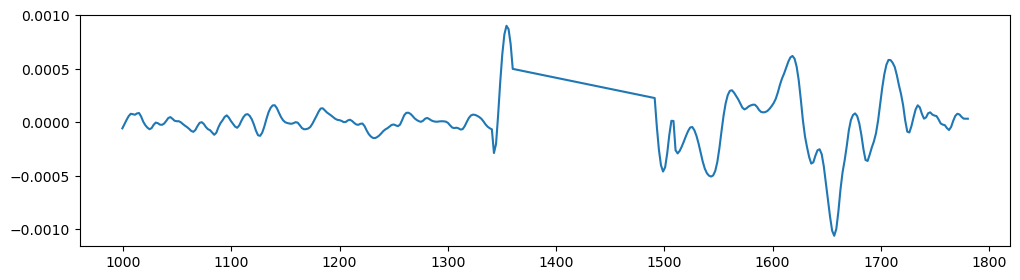

In [22]:
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(wavenumbers,core[mask][2000].T)